# LoL Prediction S11 🗡️
> League of Legends s11 Ranked Prediction

- toc: true 
- badges: true
- comments: true
- author: Jaekang Lee
- image: images/janna.jpg
- categories: [python, jupyter, CRISP-DM, League of Legends, Linear Regression, Random Forest, Udacity]

<img src="images/janna.jpg" style="width:600px;height:400px;">
<center>image src: Riot Games</center>

### Introduction
Riot Games brings massive changes to their game 'League of Legend' every year. This year, they changed their item system, drastically changing their game ecosystem. It has been few months since the big update and now players have fully adapted to the changes. Let's take a look at what happened to the ecosystem and what is the best team composition now.

- Find out what are the most popular champions now.
- Find out which team composition is the best.
- Compare Season 10 and pre-Season 11. How did the item changes impact the game?

### The dataset
The data we are going to use is a csv file obtained from scraping op.gg which is a website with League of Legend statistics. If you are interested you can visit [here](https://github.com/leejaeka/MyDatas/tree/main/lolgames). The dataset consists of 2901 ranked matches from Korea(WWW), North America(NA), Eastern Europe(EUNE), and Western Europe(EUW) servers. It has which team won the match, the total time of the match, blue team composition and red team composition. Note that only the high elo games were added this includes Challenger, Grand Master, Master and sometimes even High Diamonds. Note that there are 153 total unique champions with 'Rell' as the latest addition. Duplicate games have been removed.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

In [69]:
df = pd.read_csv ('data/s11.csv')
df = shuffle(df)
df.head()

,result,server,team_1__001,team_1__002,team_1__003,team_1__004,team_1__005,team_2__001,team_2__002,team_2__003,team_2__004,team_2__005,timestamp,game_length
1265,Defeat,www,Camille,Hecarim,Neeko,Aphelios,Sett,Rumble,Kayn,Twisted Fate,Miss Fortune,Leona,2020-12-07 18:48:25,34m 23s
1958,Defeat,eune,Kennen,Rengar,Kassadin,Miss Fortune,Bard,Kayle,Graves,Fiora,Caitlyn,Thresh,2020-12-18 18:26:55,16m 12s
1877,Victory,euw,Mordekaiser,Olaf,Zoe,Jhin,Alistar,Shen,Hecarim,LeBlanc,Aphelios,Galio,2020-12-30 08:58:13,34m 27s
778,Victory,www,Aatrox,Elise,Lucian,Miss Fortune,Pantheon,Camille,Graves,Zoe,Jhin,Leona,2020-12-29 21:49:55,18m 56s
2591,Defeat,na,Poppy,Kayn,Akali,Senna,Braum,Volibear,Olaf,Yone,Twisted Fate,Janna,2020-11-10 07:38:39,31m 15s


### Data Cleaning
1. Change game_length to continuous variable
2. Clean null values and uninformative columns
3. Change categorical variables to dummy variables


In [70]:
# Convert game_length(str) to float(seconds)
import re
date_str = df.game_length

for i in range(len(date_str)):
    if type(date_str[i]) == str:
        p = re.compile('\d*')
        min = float(p.findall(date_str[i][:2])[0])
        temp = p.findall(date_str[i][-3:])
        for j in temp:
            if j != '':
                sec = float(j)
                break
        date_str[i] = (60*min+sec)
    else: 
        date_str[i] = date_str[i]
#     print(date_str[i])
# print(len(date_str))

# remove timestamp since it does not affect the game
df = df.drop(['timestamp'], axis=1)

In [71]:
df.describe()

,result,server,team_1__001,team_1__002,team_1__003,team_1__004,team_1__005,team_2__001,team_2__002,team_2__003,team_2__004,team_2__005,game_length
count,2901,2901,2901,2901,2901,2901,2901,2901,2901,2901,2901,2901,2901.0
unique,2,4,96,62,102,70,56,95,58,102,72,63,235.0
top,Defeat,www,Camille,Graves,Akali,Jhin,Leona,Camille,Graves,Yone,Kai'Sa,Leona,1818.0
freq,2271,1592,305,581,235,590,355,266,504,226,568,381,100.0


### Most popular champions 
- Camille(Top): 19.68% pick rate
- Graves(Jg): 37.4% pick rate
- Akali/Yone(Mid): 15.89% pick rate combined
- Jhin/Kai'sa(Adc): 39.92% pick rate combined
- Leona(Supp): 25.37% pick rate <br>

Notes:
- The result is very skewed because there are 2271 Red Team win compared to only 630 Blue Team wins
- There are in total 2901 games and more than half of it is from Korean server

In [72]:
# see if there are any null values
no_nulls = set(df.columns[df.isnull().sum()==0])
print(no_nulls)

{'result', 'server', 'team_1__004', 'team_2__003', 'team_1__001', 'team_2__005', 'team_1__003', 'team_2__001', 'game_length', 'team_1__002', 'team_1__005', 'team_2__004', 'team_2__002'}


So there are no null values which is good!

In [73]:
# Categorical Columns
cat_cols = ['result', 'server', 'team_1__004', 'team_2__003', 'team_1__001', 'team_2__005', 'team_1__003', 'team_2__001','team_1__002', 'team_1__005', 'team_2__004', 'team_2__002']

def create_dummy_df(df, cat_cols):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    
    OUTPUT:
    df - new dataframe with following characteristics:
        1. contains all columns that were not specified as categorical
        2. removes all the original columns in cat_cols
        3. dummy columns for each of the categorical columns in cat_cols
        4. Use a prefix of the column name with an underscore (_) for separating
    '''
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        except:
            continue
    return df

In [74]:
df = create_dummy_df(df, cat_cols)

In [75]:
# Might as well normalize game_length as well since Linear Regression is sensitive to it
max_time = max(df['game_length'])
df=pd.concat([df.drop('game_length', axis=1), (df['game_length']/max_time)], axis=1)

In [76]:
df.head(10)

,result_Victory,server_euw,server_na,server_www,team_1__004_Akali,team_1__004_Anivia,team_1__004_Annie,team_1__004_Aphelios,team_1__004_Ashe,team_1__004_Aurelion Sol,...,team_2__002_Udyr,team_2__002_Urgot,team_2__002_Vi,team_2__002_Volibear,team_2__002_Warwick,team_2__002_Wukong,team_2__002_Xin Zhao,team_2__002_Zac,team_2__002_Zed,game_length
1265,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.700272
1958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.329939
1877,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.701629
778,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.385608
2591,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.636456
655,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.517651
1089,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.700272
1221,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.617108
1480,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.419212
1791,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.556687


The data is ready for modelling.

### Linear Regression

In [77]:
# Train test
y = df['result_Victory']
X = df.drop(['result_Victory'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

lm_model = LinearRegression(normalize=True)

In [78]:
lm_model.fit(X_train, y_train)

LinearRegression(normalize=True)

In [91]:
test_pred = lm_model.predict(X_test)
train_pred = lm_model.predict(X_train)
r2_test = r2_score(y_test, test_pred)
r2_train = r2_score(y_train, train_pred)
print("test r2: "+str(r2_test))
print("train r2: "+str(r2_train))

test r2: -2.7134011717466985e+28
train r2: 0.25972262531839096


Clearly, linear regression is a poor model for this problem haha. Makes sense since we only have discrete fields except game_length.

In [81]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [82]:
coef_df = coef_weights(lm_model.coef_, X_train)
coef_df.head(20)

,est_int,coefs,abs_coefs
435,team_2__001_Aphelios,7.451403e+14,7.451403e+14
689,team_2__004_Sion,-7.451403e+14,7.451403e+14
298,team_2__005_Ornn,5.132176e+14,5.132176e+14
248,team_1__001_Sona,-5.052884e+14,5.052884e+14
31,team_1__004_Kindred,-4.224175e+14,4.224175e+14
43,team_1__004_Pantheon,4.184556e+14,4.184556e+14
282,team_2__005_Jayce,4.156125e+14,4.156125e+14
635,team_1__005_Yasuo,3.822057e+14,3.822057e+14
595,team_1__005_Ekko,3.822057e+14,3.822057e+14
412,team_1__003_Thresh,-3.822057e+14,3.822057e+14


Recall that 1 = Blue win and 0 = Red win. So positive coefs. here means helpful for the Blue team and negative coefs. means helpful for the Red team. Most of the fields in the top 20 table above, are not something we see often. For example 435-aphelios(top), 689-sion(adc), 248-sona(top) are considered troll. Here are some other findings.
- Looks like every lane is somewhat equally important as their appearance in the table above are similiar
- Most of these are troll picks negatively affecting its own team's winrate
- Picks that are actually helping team's winrate: Sion(ADC), Pantheon(ADC), Yasuo(Sup)??, Ekko(Sup)??
- This table raises more questions than answers!

### Random Forests

In [92]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=2000, max_leaf_nodes=32, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=32, n_estimators=2000, n_jobs=-1)

In [94]:
y_test_pred = rnd_clf.predict(X_test)
test_acc = np.sum(y_test_pred == y_test)/len(y_test)
print("test accuracy: "+str(test_acc))

test accuracy: 0.8003442340791739


Wow we went from 0% to 80% accuracy with random forest!

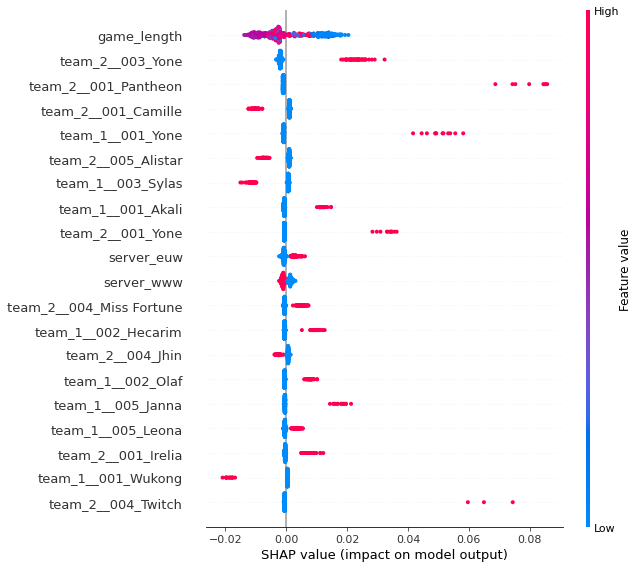

In [96]:
import shap

explainer = shap.TreeExplainer(rnd_clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

Interestingly, West Europe tend to win more as Blue team as games are longer. In contrast, Korea tend to win more as Red Team as games gets longer. So there seem to be a trend difference between regions. Furthermore, in general, the shorter the game, blue team wins more for some reason I cannot figure out. 

### Best/Worst Composition
Best
- (Top)Camille,Yone (Jg)Hecarim,Olaf,Twitch (Mid)Akali (Adc)Miss Fortune,Jhin (Sup)Alistar,Janna,Leona <br>

Worst
- (Top)Pantheon,Irelia (Jg)Wukong (Mid)Sylas,Yone 

If we compare this with the official na.op.gg champion rankings, all the best champions listed here are also listed on their website as either tier one or two as well. (Except Twitch and Pantheon).
<img src="images/tiers.png" style="width:800px;height:300px;">
Note that this is just for comparison. Op.gg has million times more data with more regions. Also how they rank these champions are not revealed.

### Comparing with S10

<center> Best team composition</center>

In [2]:
#hide_input
from fastbook import *
from fastai.vision.widgets import *

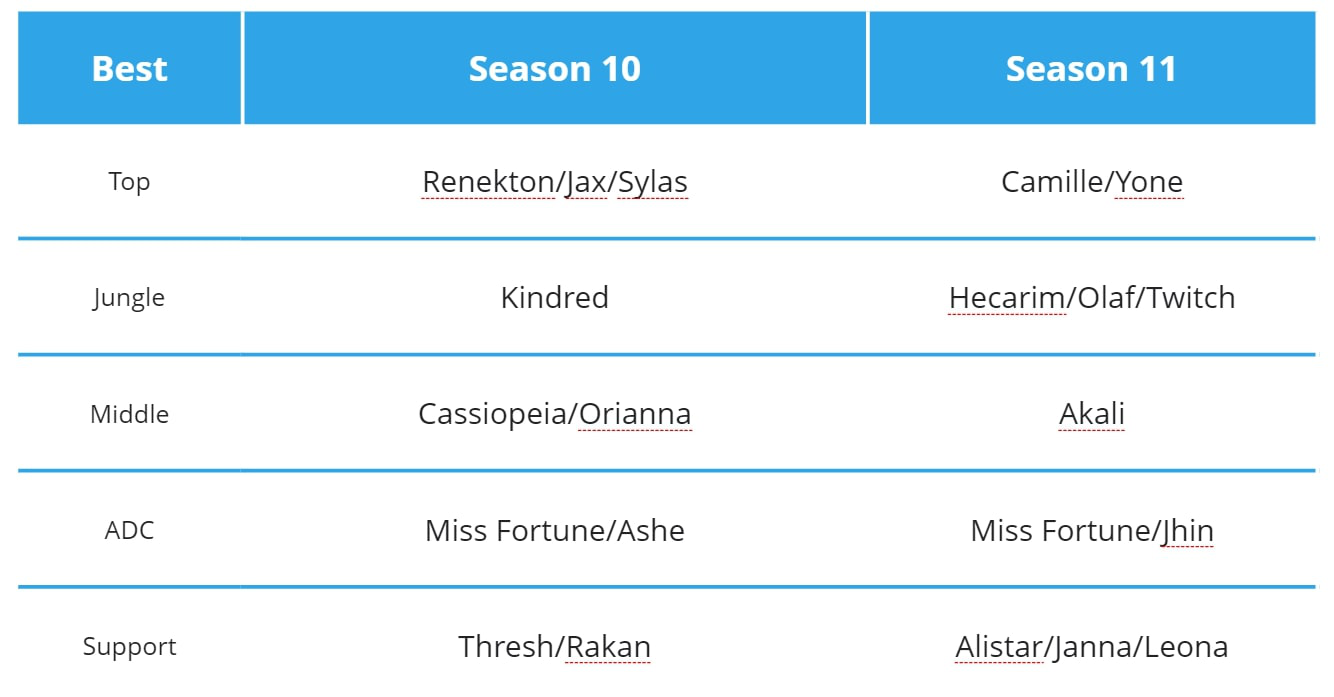

In [5]:
#hide_input
monty = PILImage.create("images/good.jpg")
display(monty)

<center> Worst team composition</center>

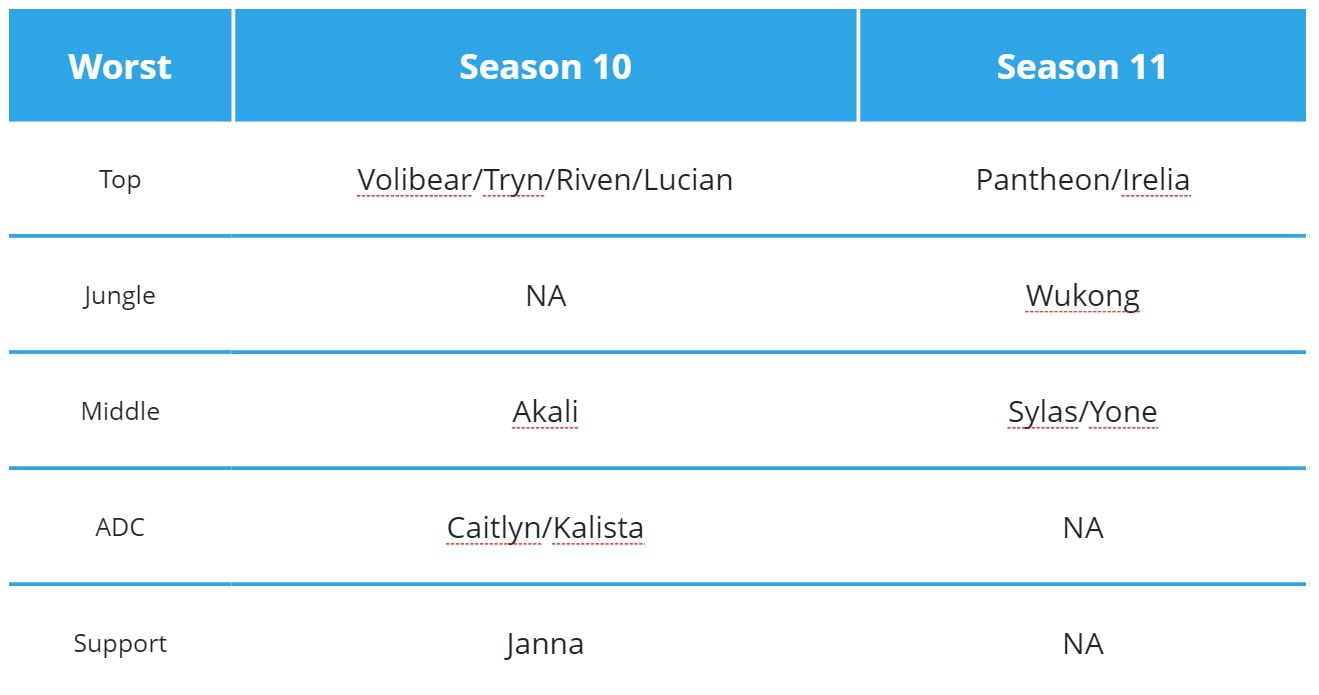

In [7]:
#hide_input
monty = PILImage.create("images/bad.jpg")
display(monty)

Comparisons
   - The new update caused each roles to impact more evenly to the game's result
   - Bottom lane has generally good picks with no worst picks in season 11.
   - The new update caused more 'high risk high reward' champions to win more and 'generally good' champions to fall
    